<a href="https://colab.research.google.com/github/leem928/leem928/blob/main/blinker_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

zip_path = "/content/blinker.zip"
extract_path = "/content/blinker"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ 압축 해제 완료: {extract_path}")

✅ 압축 해제 완료: /content/blinker


In [2]:
#1. Import 및 Custom Dataset 정의
import os, json, torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import matplotlib.pyplot as plt

class CustomFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(self.label_dir, base_name + ".json")

        image = Image.open(img_path).convert("RGB")
        width, height = image.size

        with open(label_path, 'r') as f:
            data = json.load(f)

        boxes, labels = [], []
        for obj in data.get("objects", []):
            if obj["class_name"] in ["vehicular_signal", "pedestrian_signal"]:
                x1, y1 = obj["data"][0]
                x2, y2 = obj["data"][1]
                boxes.append([x1, y1, x2, y2])
                labels.append(1)  # single class: traffic signal

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            image = self.transforms(image)

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))

In [3]:
# 2. Dataset 및 DataLoader 구성
from torchvision import transforms

resize_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_dataset = CustomFasterRCNNDataset(
    image_dir="/content/blinker/blinker/train/images",
    label_dir="/content/blinker/blinker/train/labels",
    transforms=ToTensor()
)
val_dataset = CustomFasterRCNNDataset(
    image_dir="/content/blinker/blinker/val/images",
    label_dir="/content/blinker/blinker/val/labels",
    transforms=ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [4]:
# 3. Faster R-CNN 모델 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 170MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# 빈 라벨 필터링 함수
def filter_dataset(dataset):
    filtered = []
    for i in range(len(dataset)):
        _, target = dataset[i]
        if target["boxes"].shape[0] > 0:
            filtered.append(dataset.image_files[i])
    dataset.image_files = filtered
    return dataset

# 필터링 적용
train_dataset = filter_dataset(train_dataset)
val_dataset = filter_dataset(val_dataset)

# 학습 루프
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad],
                      lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_loss += losses.item()
        except Exception as e:
            print(f"샘플 스킵됨 (오류): {e}")
            continue

    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}")

100%|██████████| 203/203 [02:12<00:00,  1.53it/s]


[Epoch 1] Loss: 50.2487


100%|██████████| 203/203 [02:11<00:00,  1.54it/s]


[Epoch 2] Loss: 29.7518


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 3] Loss: 20.8726


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 4] Loss: 18.1494


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 5] Loss: 16.3854


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 6] Loss: 17.3720


100%|██████████| 203/203 [02:10<00:00,  1.55it/s]


[Epoch 7] Loss: 13.6812


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 8] Loss: 12.8096


100%|██████████| 203/203 [02:12<00:00,  1.53it/s]


[Epoch 9] Loss: 11.3555


100%|██████████| 203/203 [02:10<00:00,  1.56it/s]


[Epoch 10] Loss: 11.1755


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 11] Loss: 10.0825


100%|██████████| 203/203 [02:10<00:00,  1.55it/s]


[Epoch 12] Loss: 10.1843


100%|██████████| 203/203 [02:12<00:00,  1.53it/s]


[Epoch 13] Loss: 9.5621


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 14] Loss: 9.3252


100%|██████████| 203/203 [02:10<00:00,  1.55it/s]


[Epoch 15] Loss: 8.7327


100%|██████████| 203/203 [02:09<00:00,  1.57it/s]


[Epoch 16] Loss: 8.6130


100%|██████████| 203/203 [02:10<00:00,  1.56it/s]


[Epoch 17] Loss: 8.4399


100%|██████████| 203/203 [02:11<00:00,  1.55it/s]


[Epoch 18] Loss: 8.0841


100%|██████████| 203/203 [02:11<00:00,  1.54it/s]


[Epoch 19] Loss: 8.0197


100%|██████████| 203/203 [02:11<00:00,  1.54it/s]

[Epoch 20] Loss: 7.1267


In [6]:
# 5. 시각화 함수
def visualize_each_image(dataset, indices):
    model.eval()
    for idx in indices:
        image, _ = dataset[idx]
        image = image.to(device)
        with torch.no_grad():
            pred = model([image])[0]
        img_np = image.cpu().permute(1, 2, 0).numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(img_np)
        boxes = pred['boxes'].cpu()
        scores = pred['scores'].cpu()
        for box, score in zip(boxes, scores):
            if score > 0.5:
                x1, y1, x2, y2 = box
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                                  edgecolor='red', facecolor='none', linewidth=2))
                plt.text(x1, y1 - 5, f"{score:.2f}", color='yellow', fontsize=12)
        plt.axis('off')
        plt.title(f"Image {idx}")
        plt.show()

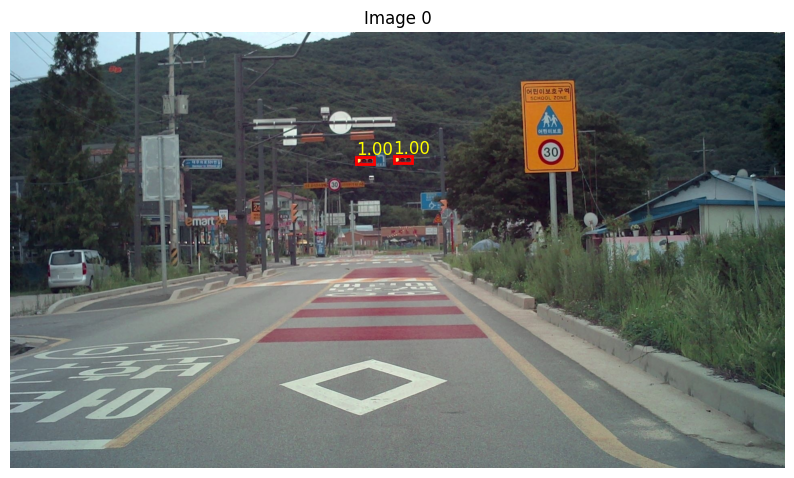

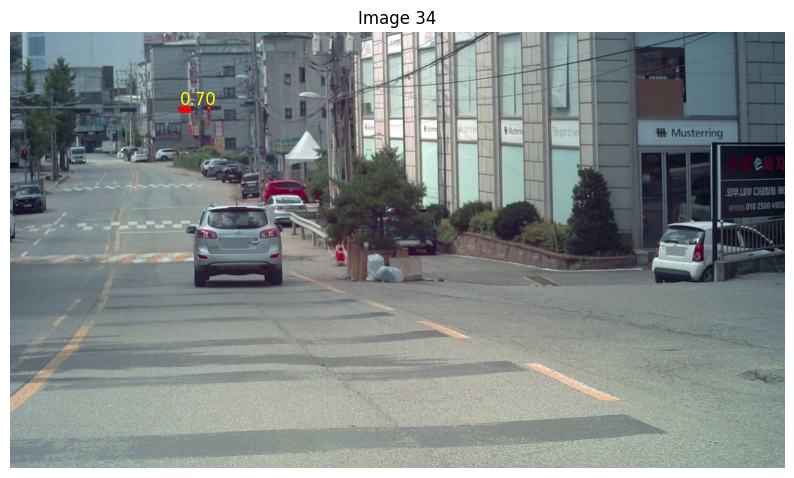

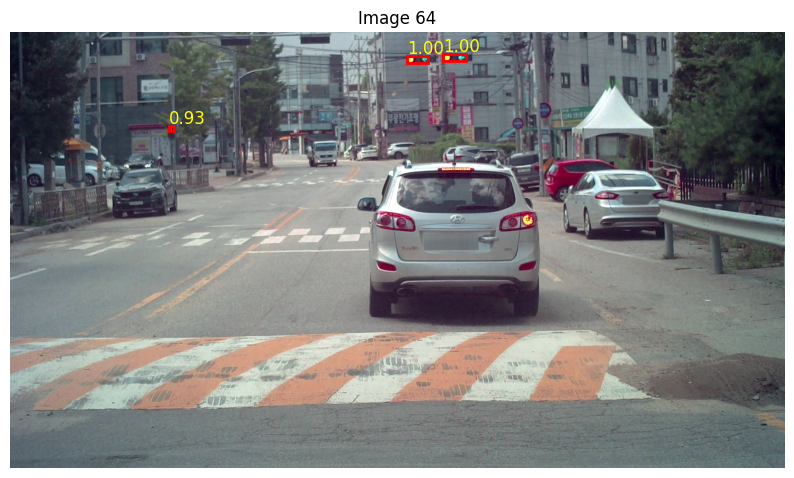

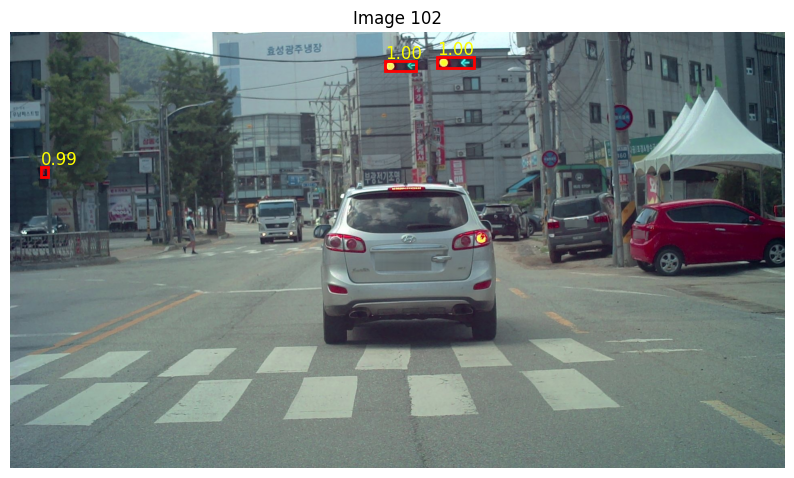

In [24]:
visualize_each_image(val_dataset, [0, 34, 64, 102])

In [25]:
# 6. 성능 지표 계산 함수
def evaluate_map(model, dataloader, iou_threshold=0.5):
    model.eval()
    tp, fp, fn = 0, 0, 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            for pred, gt in zip(outputs, targets):
                if len(pred['boxes']) == 0 and len(gt['boxes']) == 0: continue
                elif len(pred['boxes']) == 0: fn += len(gt['boxes']); continue
                elif len(gt['boxes']) == 0: fp += len(pred['boxes']); continue
                ious = box_iou(pred['boxes'], gt['boxes'])
                matches = ious > iou_threshold
                matched_gt = set()
                matched_pred = set()
                for i in range(matches.shape[0]):
                    for j in range(matches.shape[1]):
                        if matches[i, j] and j not in matched_gt:
                            matched_gt.add(j)
                            matched_pred.add(i)
                            break
                tp += len(matched_gt)
                fp += len(pred['boxes']) - len(matched_pred)
                fn += len(gt['boxes']) - len(matched_gt)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"\n📊 평가 결과 (IoU > {iou_threshold} 기준):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

In [26]:
evaluate_map(model, val_loader)


📊 평가 결과 (IoU > 0.5 기준):
Precision: 0.6443
Recall   : 0.6059
F1 Score : 0.6245
